# Banking Churn Analysis

## Problem Statement

ABC Multistate Bank has observed a significant number of customers closing their accounts over a recent period. The bank wants to identify which customer characteristics and behaviours are most strongly associated with churn, build a model to predict which customers are most likely to leave, and generate clear, data-driven recommendations for targeted retention strategies

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score




## 1. Introduction
Here we import and understand data structure of our dataset

In [25]:
# Understand the basic structure of the data
df = pd.read_csv('Bank Customer Churn Prediction.csv')
ori_df = df.copy()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## 2. Exploratory Data Analysis (EDA)
EDA helps us assess data quality and uncover important patterns. In this stage, we:

-Check for missing values and duplicated records

-Remove illogical or impossible entries (e.g., unrealistic salaries)

-Examine summary statistics to understand data distribution

-Create visualisations to explore variable patterns

-Analyse relationships between features and churn


In [26]:
print(df.isna().sum()) # No missing values

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


In [27]:
print(df.duplicated().sum()) # No duplicate rows

0


In [28]:
## Checking unreasonalble values in different columns
print(df.country.value_counts()) # consist of France, Spain, Germany only
print(df.gender.value_counts()) # exactly two genders

country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64
gender
Male      5457
Female    4543
Name: count, dtype: int64


In [29]:
## Removing unneccessary columns
df = df.drop(columns=['customer_id'])

In [30]:
df.estimated_salary.describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

It is extremely unlikely that an individual’s annual salary is $11.58, especially when the median estimated salary is approximately $100,194. Since annual incomes below $10,000 are highly implausible for this dataset and are more likely due to data entry errors rather than true low-income or student workers, these values were removed to ensure data quality.

In [31]:
df.estimated_salary.mean()
df[df.estimated_salary<10000][['country','age','estimated_salary','balance']] # 508 rows

,country,age,estimated_salary,balance
16,Germany,58,5097.67,132602.88
23,France,46,8487.75,0.00
58,Spain,66,1643.11,0.00
84,France,46,1907.66,0.00
99,France,34,6534.18,0.00
...,...,...,...,...
9928,France,38,2444.29,71018.60
9943,Spain,23,6847.73,0.00
9954,France,45,3449.22,155417.61
9979,France,58,2988.28,90022.85


In [32]:
df.drop(df[df.estimated_salary<10000].index, inplace=True) # removing rows with EstimatedSalary < 10000 since they are unreasonable values

Variable Exploration and Churn Relationships

churn
0    7556
1    1936
Name: count, dtype: int64


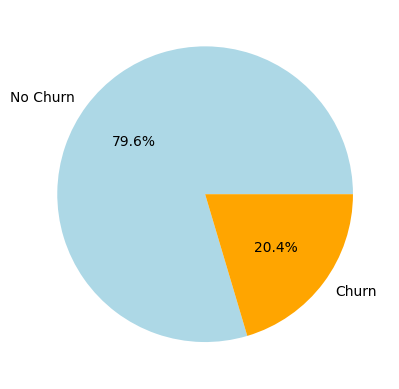

In [33]:
print(df.churn.value_counts())  # checking target variable distribution 

df['churn'].value_counts().plot.pie(
    autopct='%1.1f%%',
    labels=['No Churn','Churn'],   # 0 then 1
    colors=['lightblue','orange']
)
plt.ylabel("")   #  removes ugly label
plt.show()



In [34]:

bins = [0, 550, 600, 675, 740, 850]
labels = ['poor', 'fair', 'good', 'great', 'excellent']
df['credit_rating_category'] = pd.cut(df['credit_score'], bins=bins, labels=labels)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'poor'),
  Text(1, 0, 'fair'),
  Text(2, 0, 'good'),
  Text(3, 0, 'great'),
  Text(4, 0, 'excellent')])

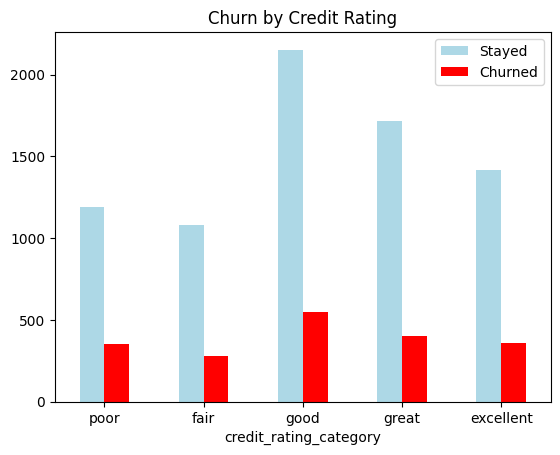

In [35]:

pd.crosstab(df['credit_rating_category'], df['churn']).plot(kind='bar',color=['lightblue','red'])
plt.legend(['Stayed','Churned'])
plt.title('Churn by Credit Rating')
plt.xticks(rotation=0)
#Shows how many customers fall into each credit rating category and how many of them churned as well as their visual ratio.

(array([0, 1, 2]),
 [Text(0, 0, 'France'), Text(1, 0, 'Germany'), Text(2, 0, 'Spain')])

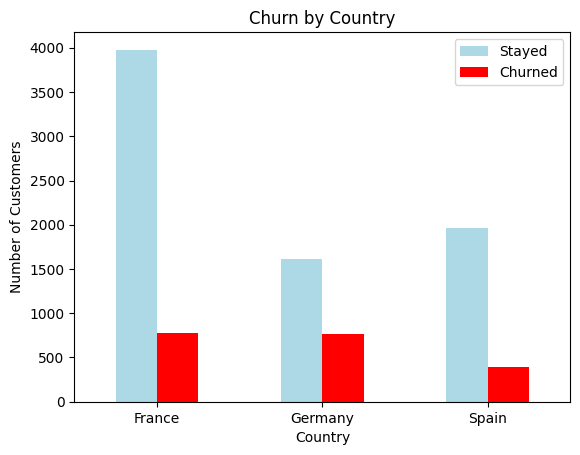

In [36]:
pd.crosstab(df['country'], df['churn']).plot(kind='bar', color=['lightblue','red'])
plt.title('Churn by Country')
plt.legend(['Stayed','Churned'])
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
# Germany has a noticeably higher churn rate compared to France and Spain

(array([0, 1]), [Text(0, 0, 'Female'), Text(1, 0, 'Male')])

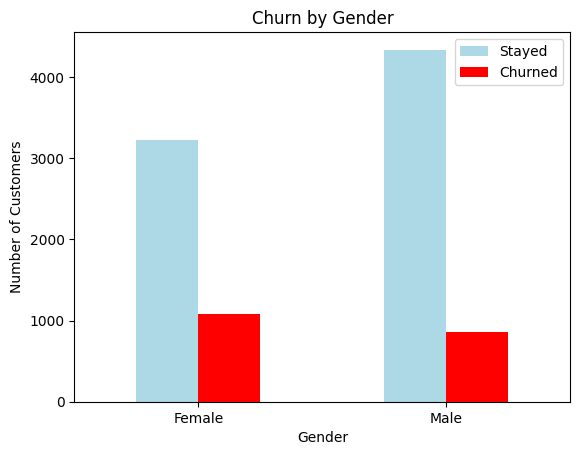

In [37]:
gender_labels = {0: 'Female', 1: 'Male'}

(pd.crosstab(df['gender'], df['churn'])
   .rename(index=gender_labels)
   .plot(kind='bar', color=['lightblue','red']))

plt.title('Churn by Gender')
plt.legend(['Stayed','Churned'])
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

#Female customers churn slightly more often than male customers, though the difference is small

(array([0, 1]), [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

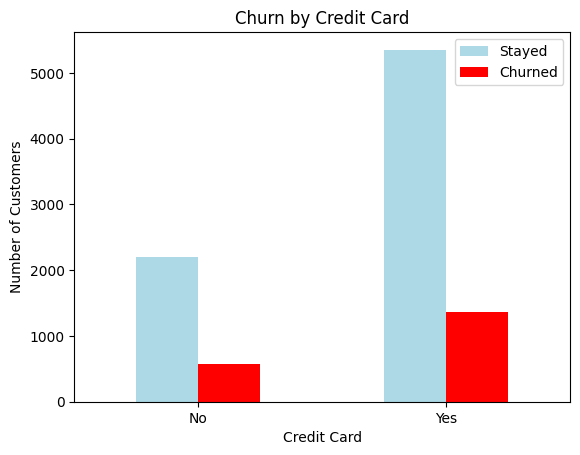

In [38]:
cc_labels = {0: 'No', 1: 'Yes'}

pd.crosstab(df['credit_card'], df['churn']).rename(index=cc_labels).plot(kind='bar', color=['lightblue','red'])
plt.title('Churn by Credit Card')
plt.legend(['Stayed','Churned'])
plt.xlabel('Credit Card')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

# Although customers with a credit card show a higher count of churners, this is only because there are far more credit-card customers overall. 
# In terms of churn rate, credit-card holders actually churn less than non-holders.

(array([0, 1]), [Text(0, 0, 'No'), Text(1, 0, 'Yes')])

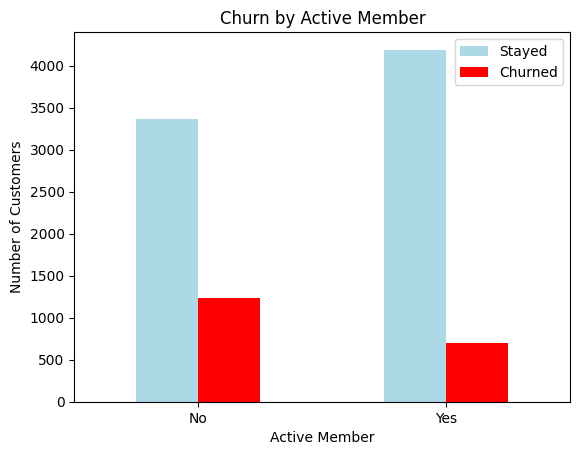

In [39]:


active_member_labels = {0: 'No', 1: 'Yes'}

pd.crosstab(df['active_member'], df['churn']).rename(index=active_member_labels).plot(kind='bar', color=['lightblue','red'])

plt.title('Churn by Active Member')
plt.legend(['Stayed','Churned'])
plt.xlabel('Active Member')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)

#Inactive customers churn significantly more than active customers.

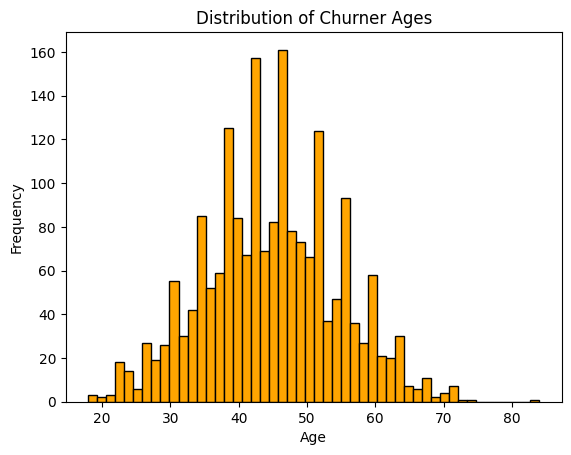

In [40]:
df[df['churn']==1]['age'].plot.hist(bins=50,edgecolor='black', color='orange')
plt.title('Distribution of Churner Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#Churn is most common among customers aged 40–59, forming a clear peak in this middle-aged group

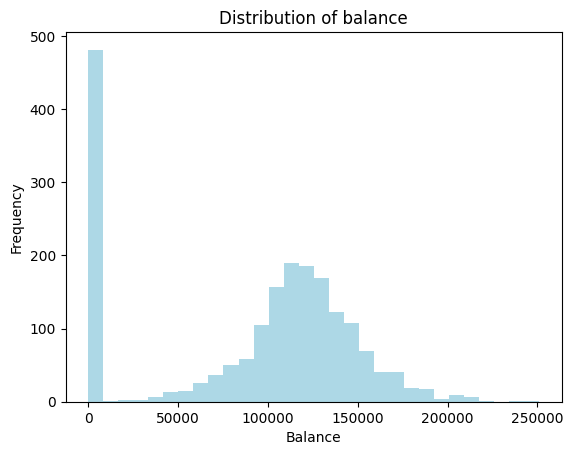

In [41]:
df[df['churn']==1]['balance'].plot.hist(bins=30, color='lightblue')
plt.title('Distribution of balance')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

#Customer balance values vary widely, but this distribution does not meaningfully differ between churners and non-churners

(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

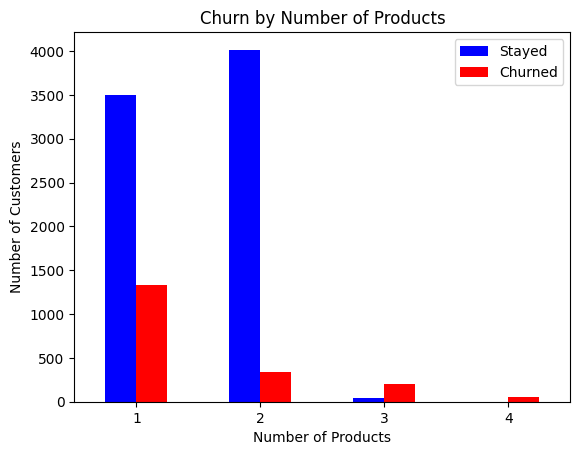

In [42]:
pd.crosstab(df['products_number'], df['churn']).plot(kind='bar', color=['blue','red'])
plt.title('Churn by Number of Products')
plt.legend(['Stayed','Churned'])
plt.xlabel('Number of Products')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
#Customers with only one product are more likely to churn compared to those with multiple products, yet 3 and above shows otherwise

/tmp/ipykernel_7316/1046441488.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('credit_rating_category')['churn'].mean().plot(kind='bar')


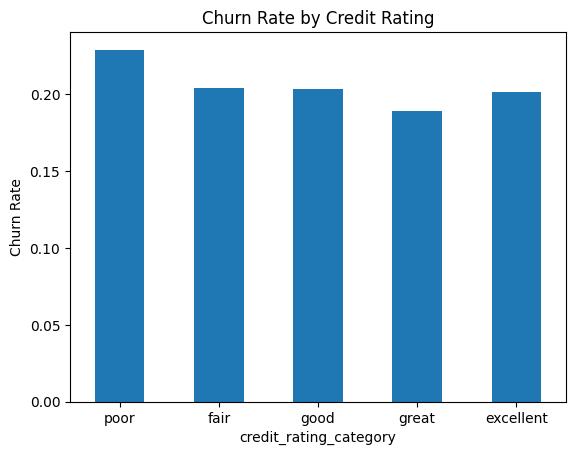

In [43]:
# Group and plot in one line
df.groupby('credit_rating_category')['churn'].mean().plot(kind='bar')
plt.title('Churn Rate by Credit Rating')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.show()

#Customers with lower credit ratings churn slightly more, with the ‘poor’ group showing the highest churn rate, 
# although the differences across categories are relatively small.

## 2.5 Data Preprocessing
This section preprocesses the data so it can be used reliably for modelling and analysis.

In [44]:
le = LabelEncoder()
df.gender = le.fit_transform(df.gender) # Female = 0, Male = 1


In [45]:
df = pd.get_dummies(df, columns=['country'], prefix='country', drop_first=False)

# endode country column for correlation analysis

In [46]:
df[['country_Germany','country_Spain']] = \
    df[['country_Germany','country_Spain']].astype(int)


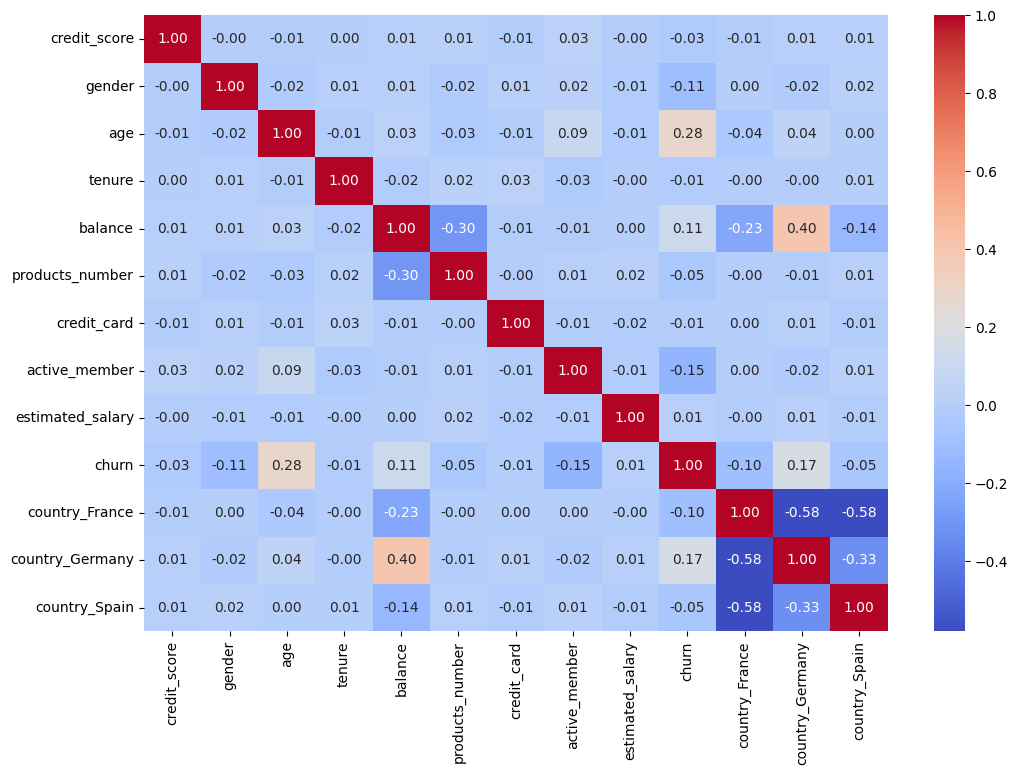

In [47]:
df_corr = pd.get_dummies(df.drop(columns=['credit_rating_category']), drop_first=False)
corr = df_corr.corr()
plt.figure(figsize=(12,8))

sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

plt.show()

#Churn shows weak correlations overall, with age, country_germany, and active membership standing out as the strongest (though still modest) predictors.

In [48]:
corr['churn'].abs().sort_values(ascending=False).drop('churn')
# Show correlation values with churn column

age                 0.283678
country_Germany     0.167747
active_member       0.154633
balance             0.113309
gender              0.106299
country_France      0.100004
country_Spain       0.052632
products_number     0.046990
credit_score        0.028010
tenure              0.014131
estimated_salary    0.012141
credit_card         0.005281
Name: churn, dtype: float64

In [49]:
active_member_churn_diff = df.groupby('active_member')['churn'].mean()[0]/df.groupby('active_member')['churn'].mean()[1]

print(f"Inactive customers are {active_member_churn_diff:.2f} times more likely to churn than active customers.")




Inactive customers are 1.87 times more likely to churn than active customers.


In [50]:
bins = [0, 19, 29, 39, 59, 200]
labels = ['Teenager (18-19)', 'Young Adult (20-29)', 'Adult (30-39)',
          'Middle-Aged (40-59)', 'Senior (60+)']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

print(df.groupby('age_group')['churn'].mean())



age_group
Teenager (18-19)       0.068182
Young Adult (20-29)    0.076260
Adult (30-39)          0.109056
Middle-Aged (40-59)    0.368690
Senior (60+)           0.283730
Name: churn, dtype: float64


/tmp/ipykernel_7316/1149861857.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('age_group')['churn'].mean())


In [51]:
print(ori_df.groupby('country')['churn'].mean())

country
France     0.161548
Germany    0.324432
Spain      0.166734
Name: churn, dtype: float64


## 3. Key insights from EDA
Important findings:
1. Churn rate consists of approximately 20% of the dataset
2. Middle-Aged customers (40-59) has the highest churn rate at 36.87%
3. German customers churn at a rate of 32.4% is approximately 2× higher than French (16.2%) and Spanish (16.7%) customers
4. Inactive customers are 1.87 times more likely to churn than active customers.


## 4. Data modelling
Since churn prediction is a binary classification problem where we need to identify whether a customer will leave or stay, we use three different classification models: Logistic Regression to provide a simple linear baseline, Random Forest to capture non-linear relationships through decision trees, and XGBoost to leverage gradient boosting for stronger predictive performance.

In [52]:
# Preparing data for model training
X = df.drop(['churn','credit_rating_category','age_group'] , axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# random_state=42 is a seed, stratify=y keeps churn ratio same in train + test, test_size makes it 80/20



In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# X_encoded is your already-encoded dataframe (all numeric)
# X = X_encoded
# y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 1) scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) logistic regression with more iterations
model = LogisticRegression(max_iter=5000)
model.fit(X_train_scaled, y_train)


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # probability of class 1
    
    print("Accuracy:         ", accuracy_score(y_test, y_pred))
    print("Precision:        ", precision_score(y_test, y_pred))
    print("Recall:           ", recall_score(y_test, y_pred))
    print("F1 Score:         ", f1_score(y_test, y_pred))
    print("AUC Score:        ", roc_auc_score(y_test, y_prob))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("==== Logistic Regression ====")
evaluate_model(model, X_test_scaled, y_test)

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=850,
    random_state=1200,
    max_depth = 19,
    class_weight='balanced'  # better for churn imbalance
)

model_rf.fit(X_train, y_train)

print("==== Random Forest ====")
evaluate_model(model_rf, X_test, y_test)


from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    eval_metric='logloss', 
    learning_rate=0.05,
    n_estimators=500,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train, y_train)
print("==== XGBoost ====")
evaluate_model(model_xgb, X_test, y_test)


==== Logistic Regression ====
Accuracy:          0.8104265402843602
Precision:         0.5985401459854015
Recall:            0.21188630490956073
F1 Score:          0.31297709923664124
AUC Score:         0.7446372175054345

Confusion Matrix:
 [[1457   55]
 [ 305   82]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1512
           1       0.60      0.21      0.31       387

    accuracy                           0.81      1899
   macro avg       0.71      0.59      0.60      1899
weighted avg       0.78      0.81      0.77      1899

==== Random Forest ====
Accuracy:          0.8641390205371248
Precision:         0.7721518987341772
Recall:            0.4728682170542636
F1 Score:          0.5865384615384616
AUC Score:         0.8456003992179703

Confusion Matrix:
 [[1458   54]
 [ 204  183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96     

XGBoost is the best-performing model based on statistical evaluation.
It achieved the highest AUC score, indicating superior discriminative ability between churn and non-churn customers.
Additionally, XGBoost delivered the best recall and F1 score, meaning it detects the largest proportion of churners while maintaining a balanced precision.
The confusion matrix further confirms the lowest number of false negatives, which is critical for churn prediction.
Therefore, statistically, XGBoost is the strongest model.

The model achieves 85% accuracy, correctly identifying most non-churners (94% recall for class 0). However, it detects 50% of actual churners (class 1), which is typical for an imbalanced churn dataset. Precision for churners is 0.69, meaning most predicted churners are correct. Overall, the model provides a strong separation between churn and non-churn customers, with a balanced F1 score for class 1.

In [57]:


importances = model_xgb.feature_importances_

# convert to pandas series for readability
importances_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
importances_series



products_number     0.267550
active_member       0.154950
age                 0.130911
country_Germany     0.098674
gender              0.059219
balance             0.056966
country_Spain       0.043386
country_France      0.039658
estimated_salary    0.039417
credit_score        0.038365
tenure              0.035509
credit_card         0.035396
dtype: float32

The XGBoost feature importance results show that products_number becomes the strongest predictor of churn, even more influential than suggested by the correlation matrix. Other key drivers such as active_member, age, and country_Germany appear consistently important in both the correlation analysis and the model, confirming their strong relationship with churn

In [58]:
churn_sum = df.groupby('products_number')['churn'].sum()
churn_count = df.groupby('products_number')['churn'].count()
churn_rate_products_number = churn_sum / churn_count
churn_rate_products_number

products_number
1    0.276583
2    0.077011
3    0.824701
4    1.000000
Name: churn, dtype: float64

New findings from product numbers have shown from 1 to 2 products, we see a clear drop in churn, likely because customers become more engaged and rely more on the bank. However, churn suddenly spikes for 3–4 products, which is almost entirely due to the very small group size in those categories. As a result, the churn rates for 3–4 products have little real reference value.


BUSINESS IMPACT ANALYSIS

Confusion Matrix:
[[1426   86]
 [ 194  193]]

Business Metrics (Based on Test Set):

Correctly identified churners (TP): 193
Missed churners (FN): 194
Predicted churn (TP + FP): 279

Revenue Impact:
   Customers saved (30% success): 57
   Revenue saved: $2,850,000
   Revenue lost (missed churners): $9,700,000

Cost Analysis:
   Retention cost: $139,500

Net Impact:
   Net Benefit: $2,710,500
   ROI: 1943.0%


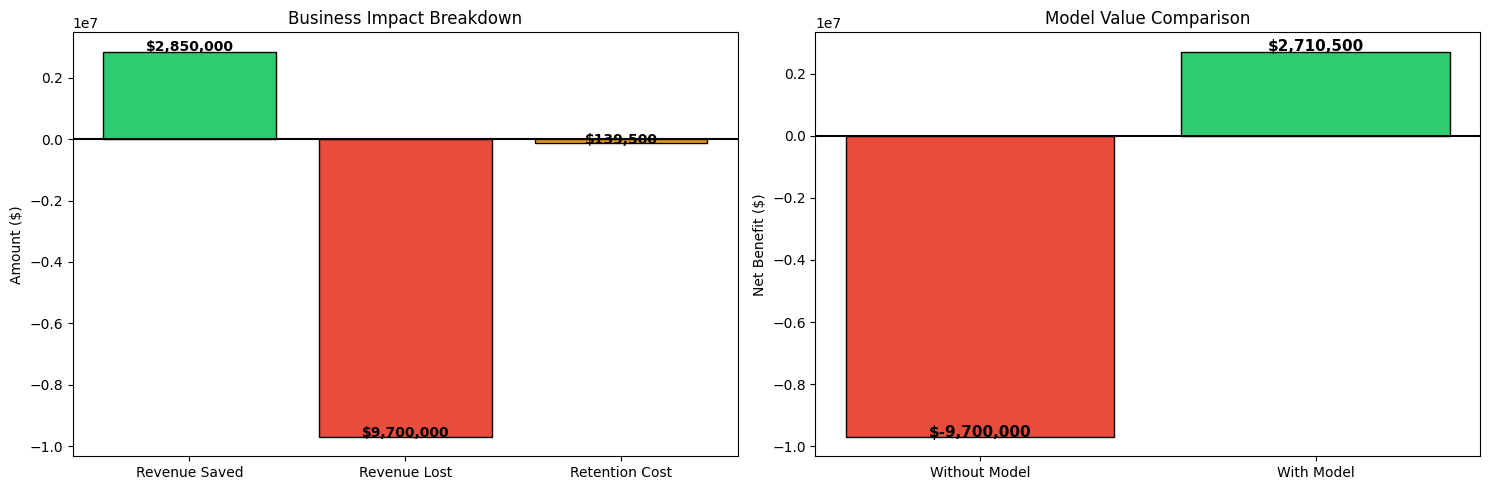

In [59]:
from sklearn.metrics import confusion_matrix

print("\n" + "=" * 70)
print("BUSINESS IMPACT ANALYSIS")
print("=" * 70)

# 1. Get predictions from the XGBoost model
y_pred = model_xgb.predict(X_test)
y_prob = model_xgb.predict_proba(X_test)[:, 1]

# 2. Confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# 3. Business assumptions
avg_customer_value = 50000       # Average revenue/value of a retained customer
retention_cost = 500             # Cost of retention campaign per customer
retention_success_rate = 0.30    # 30% of contacted churners decide to stay

# 4. Business calculations
saved_customers = int(tp * retention_success_rate)
revenue_saved = saved_customers * avg_customer_value
lost_revenue = fn * avg_customer_value

retention_spending = (tp + fp) * retention_cost
net_benefit = revenue_saved - retention_spending
roi = (net_benefit / retention_spending) * 100 if retention_spending > 0 else 0

# 5. Print interpretive results
print(f"\nConfusion Matrix:\n{cm}")

print("\nBusiness Metrics (Based on Test Set):\n")

print(f"Correctly identified churners (TP): {tp}")
print(f"Missed churners (FN): {fn}")
print(f"Predicted churn (TP + FP): {tp + fp}")

print("\nRevenue Impact:")
print(f"   Customers saved (30% success): {saved_customers}")
print(f"   Revenue saved: ${revenue_saved:,.0f}")
print(f"   Revenue lost (missed churners): ${lost_revenue:,.0f}")

print("\nCost Analysis:")
print(f"   Retention cost: ${retention_spending:,.0f}")

print("\nNet Impact:")
print(f"   Net Benefit: ${net_benefit:,.0f}")
print(f"   ROI: {roi:.1f}%")

# 6. Plot business impact
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart 1: Breakdown
impact_categories = ['Revenue Saved', 'Revenue Lost', 'Retention Cost']
impact_values = [revenue_saved, -lost_revenue, -retention_spending]
colors = ['#2ecc71', '#e74c3c', '#f39c12']

axes[0].bar(impact_categories, impact_values, color=colors, edgecolor='black')
axes[0].axhline(0, color='black')
axes[0].set_title("Business Impact Breakdown")
axes[0].set_ylabel("Amount ($)")
for i, v in enumerate(impact_values):
    axes[0].text(i, v + (5000 if v > 0 else -8000), f"${abs(v):,.0f}", 
                 ha='center', fontsize=10, fontweight='bold')

# Bar chart 2: With vs Without Model
without_model = -fn * avg_customer_value   # lose all churners
with_model = net_benefit

axes[1].bar(['Without Model', 'With Model'], [without_model, with_model],
            color=['#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].axhline(0, color='black')
axes[1].set_title("Model Value Comparison")
axes[1].set_ylabel("Net Benefit ($)")
for i, v in enumerate([without_model, with_model]):
    axes[1].text(i, v + (5000 if v > 0 else -8000), f"${v:,.0f}",
                 ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
